In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from os import getcwd, path as path_lib
import math

log_path = path_lib.join(getcwd(), "ConSteer")
scene_path = path_lib.join(getcwd().split("\\")[0].upper()+"\\",*getcwd().split("\\")[1:-1],"Project-Code","Scenarios","All_2Cop.csv")
# for scene_path use scene.csv not scene_swarm_position.csv file path
# for log_path link to drone log file directory that matches with the scene

In [2]:
drone_ids = [*range(50,52)]
files = glob(path_lib.join(log_path,"*.log"))

len(files) == len(drone_ids)

True

In [3]:
drone_protocol = dict()

for d_id,file_path in zip(drone_ids,files):
    drone_protocol[d_id] = dict()
    with open(file_path,"r") as file:
        lines = file.readlines()
        for line in lines[1:-1]:
            key = float(line.split("]")[0].strip("[").strip())
            pos = [float(coord.strip()) for coord in line.split("pos:")[-1].split("/")[0].split(",")]
            drone_protocol[d_id][key] = pos

print(drone_protocol.keys())
for key in drone_protocol.keys():
    print("-> protocol from drone "+str(key)+": ")
    print("   first_timestamp:",list(drone_protocol[key].keys())[0])
    print("   first_pos:",drone_protocol[key][list(drone_protocol[key].keys())[0]])
    print("   timestamp_amount:",len(drone_protocol[key].keys()))


dict_keys([50, 51])
-> protocol from drone 50: 
   first_timestamp: 0.02931
   first_pos: [52.13591652, 11.64344738]
   timestamp_amount: 317
-> protocol from drone 51: 
   first_timestamp: 0.02931
   first_pos: [52.13741233, 11.64344738]
   timestamp_amount: 317


In [4]:
scene = dict()

with open(scene_path, "r") as file:
    lines = file.readlines()
    for line in lines[2:]:
        vals = [val.strip() for val in line.split(",")]
        scene[vals[-1]] = scene.get(vals[-1], [])
        scene[vals[-1]].append([round(float(vals[0]),8),round(float(vals[1]),8)])

print(scene.keys())
for key in scene.keys():
    print("-> "+str(key)+"s in scene: ")
    print("   first_"+str(key)+":",scene[key][0])
    print("   "+str(key)+"_amount:",len(scene[key]))

dict_keys(['att', 'rep', 'spawn'])
-> atts in scene: 
   first_att: [52.13716576, 11.64242715]
   att_amount: 1
-> reps in scene: 
   first_rep: [52.13741576, 11.64354715]
   rep_amount: 3
-> spawns in scene: 
   first_spawn: [52.13591576, 11.64344715]
   spawn_amount: 2


In [5]:
#gets the metric distance between two points given in the LlaCoor_f format
def getDistance(own_pos_lat, own_pos_lon, goal_pos_lat, goal_pos_lon)->float:
    #GLOBE_RADIUS:int = int(6371000)
    return float( 6371000 * math.acos(                  
        math.sin(own_pos_lat) * math.sin(goal_pos_lat) +    
        math.cos(own_pos_lat) * math.cos(goal_pos_lat) *    
        math.cos(own_pos_lon - goal_pos_lon)
    )/100)

GOAL Achievement Analysis

In [6]:
reached = {}
last_goal = 0
for timestamp in drone_protocol[list(drone_protocol.keys())[0]].keys():
    for d_id in drone_protocol.keys():
        for att_id, att in enumerate(scene["att"]):
            if getDistance(*drone_protocol[d_id][timestamp],*att) < 1.5 \
            and not reached.get(str(d_id)+"->"+str(att_id), None):
                reached[str(d_id)+"->"+str(att_id)] = [*[drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()],timestamp-last_goal]

for key in reached.keys():
    print("Drone",key.split("->")[0],"reached ATT_Point",key.split("->")[1],"approximately after",
    str(reached[key][-1])+"sec.")

Drone 51 reached ATT_Point 0 approximately after 101.676392sec.


DANGER Avoidance Analysis

In [7]:
min_dist = {}
for timestamp in drone_protocol[list(drone_protocol.keys())[0]].keys():
    for d_id in drone_protocol.keys():
        for rep_id, rep in enumerate(scene["rep"]):
            dist = getDistance(*drone_protocol[d_id][timestamp],*rep)
            if not min_dist.get(str(d_id)+"->"+str(rep_id), None) \
            or dist < min_dist[str(d_id)+"->"+str(rep_id)][1]:
                min_dist[str(d_id)+"->"+str(rep_id)] = [timestamp, dist]

for key in min_dist.keys():
    print("Smallest distance between Drone",key.split("->")[0],"and REP_Point",key.split("->")[1],
    "was {0:.8f}m and occured".format(round(min_dist[key][1],8)),
    "{0:.6f}sec after simulation start.".format(min_dist[key][0]))

Smallest distance between Drone 50 and REP_Point 0 was 31.11945664m and occured 110.844559sec after simulation start.
Smallest distance between Drone 50 and REP_Point 1 was 28.14960489m and occured 110.844559sec after simulation start.
Smallest distance between Drone 50 and REP_Point 2 was 26.16047745m and occured 110.844559sec after simulation start.
Smallest distance between Drone 51 and REP_Point 0 was 1.88180153m and occured 28.729662sec after simulation start.
Smallest distance between Drone 51 and REP_Point 1 was 1.87796250m and occured 29.128279sec after simulation start.
Smallest distance between Drone 51 and REP_Point 2 was 1.51284692m and occured 37.499214sec after simulation start.


Behaviour Evaluation

In [8]:
result_file_path = path_lib.join(getcwd(), scene_path.split("\\")[-1].strip(".csv")+"_res.csv")


fastest_goal = min([array[-1] for array in reached.values()])
slowest_goal = max([array[-1] for array in reached.values()])
avg_goal = np.average([array[-1] for array in reached.values()])

print("Goal Stats:\n-----------")
print("Shortest travel time to goal: {:.6f}sec".format(fastest_goal))
print("Average  travel time to goal: {:.6f}sec".format(avg_goal))
print("Longest  travel time to goal: {:.6f}sec".format(slowest_goal))



smallest_dist = min([tuplett[1] for tuplett in min_dist.values()])
furthest_dist = max([tuplett[1] for tuplett in min_dist.values()])
avg_dist = np.average([tuplett[1] for tuplett in min_dist.values()])

print("\nDanger Stats:\n-------------")
print("Smallest minimal distance to danger: {:.12f}m".format(round(smallest_dist,12)))
print("Average  minimal distance to danger: {:.12f}m".format(round(avg_dist,12)))
print("Furthest minimal distance to danger: {:.12f}m".format(round(furthest_dist,12)))


with open(result_file_path, "w") as results:
    results.write(str(slowest_goal)+","+str(avg_goal)+","+str(fastest_goal)+"\n")
    results.write("{:.12f},{:.12f},{:.12f}".format(round(smallest_dist,12),round(avg_dist,12),round(furthest_dist,12)))

Goal Stats:
-----------
Shortest travel time to goal: 101.676392sec
Average  travel time to goal: 101.676392sec
Longest  travel time to goal: 101.676392sec

Danger Stats:
-------------
Smallest minimal distance to danger: 1.512846920893m
Average  minimal distance to danger: 15.117024987380m
Furthest minimal distance to danger: 31.119456636544m


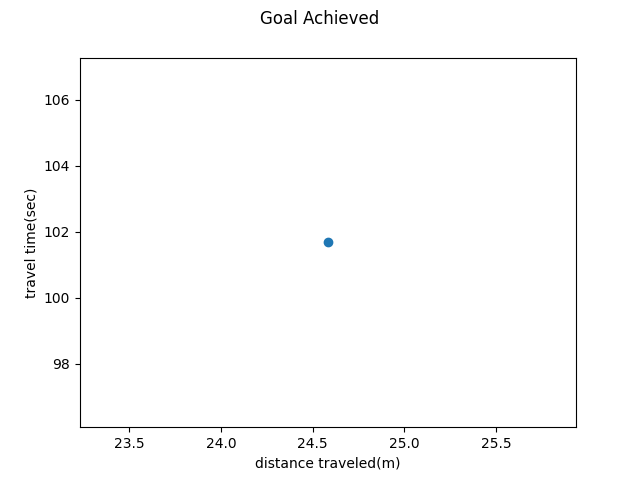

In [13]:
plt.figure()
att_ids = [key.split("->")[-1] for key in reached.keys()]
swarm_pos = [[drone_protocol[d_id][list(drone_protocol[d_id].keys())[0]] for d_id in drone_protocol.keys()]]
for array in reached.values(): swarm_pos.append(array[:-1])
att_dist = list()
for idx in range(1,len(swarm_pos)):
    dists = list()
    for prev,next in zip(swarm_pos[idx-1],swarm_pos[idx]):
        dists.append(getDistance(*prev,*next))
    att_dist.append(dists[drone_ids.index(int(list(reached.keys())[idx-1].split("->")[0]))])
plt.plot(att_dist,[array[-1] for array in reached.values()])
plt.scatter(att_dist,[array[-1] for array in reached.values()])
plt.suptitle('Goal Achieved')
plt.ylabel("travel time(sec)")
plt.xlabel("distance traveled(m)");

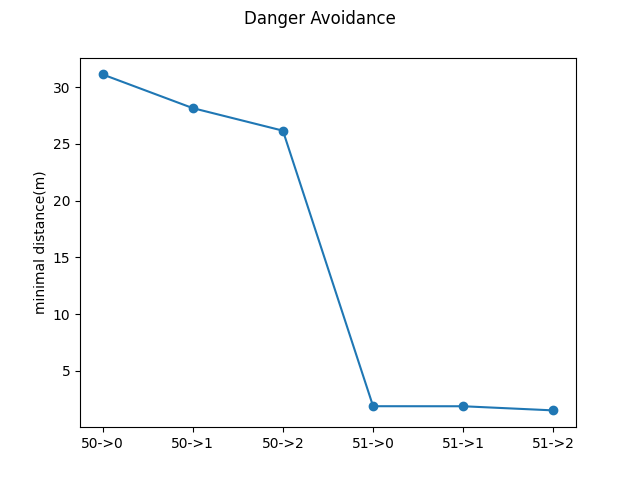

In [15]:
plt.figure()
plt.plot([*range(len(min_dist))],[tuplett[1] for tuplett in min_dist.values()])
plt.scatter([*range(len(min_dist))],[tuplett[1] for tuplett in min_dist.values()])
plt.suptitle('Danger Avoidance')
plt.ylabel("minimal distance(m)")
plt.xticks([*range(len(min_dist))],list(min_dist.keys()));